## SARSA
다음 환경(**GridWorldEnvironment**)을 가지고 SARSA를 구현하세요.

## GridWorldEnvironment
```py
start_point = (0,0)
end_point = (4,4)
gridworld_size = (5,5)
env = GridWorldEnvironment(start_point, end_point, grid_world_size)
```

## Original Code

In [17]:
import numpy as np
from typing import Tuple

class GridWorldEnvironment:
    def __init__(self, start_point:Tuple, end_point:Tuple, grid_world_size:Tuple):
        # 시작점과 끝점을 받는다.
        self.start_point = start_point
        self.end_point = end_point if end_point != (-1,-1) else (grid_world_size[0] + end_point[0],
                                                                 grid_world_size[1] + end_point[1])

        # 그리드 월드의 규격을 받는다.
        self.width, self.height = grid_world_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right']
        self.num_actions = len(self.action_space)
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) }

        # 상태 : 좌표로 나타남
        self.traces = []

        # total states
        self.total_states = []
        for x in range(self.width):
            for y in range(self.height):
                self.total_states.append((x,y))

        # reward
        self.reward = np.zeros(shape=(self.height, self.width)).tolist()
        self.reward[end_point[0]][end_point[1]] = 1

    def render(self):
        # 그리드 월드의 상태를 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 값을 삭제하기 위함
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[last_point[0]][last_point[1]] = "A" # 현재 에이전트의 위치

        # string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)

    def get_reward(self, state, action_idx):
        next_state = self.state_after_action(state, action_idx)
        return self.reward[next_state[0]][next_state[1]]

    def state_after_action(self, state, action_idx:int):
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_state = (state[0]+row_movement, state[1]+col_movement)
        next_state = self.check_boundary(next_state)

        return next_state

    def check_boundary(self, state):
        state = list(state)
        state[0] = (0 if state[0] < 0 else self.height - 1 if state[0] > self.height - 1 else state[0])
        state[1] = (0 if state[1] < 0 else self.width - 1 if state[1] > self.width - 1 else state[1])
        return tuple(state)

### 그리드월드 상속 및 오버라이딩

In [14]:
class MyGridWorldEnvironment(GridWorldEnvironment):
    def __init__(self, start_point, end_point, grid_world_size):
        super().__init__(start_point, end_point, grid_world_size)
        # 시작 위치를 traces에 추가하여 초기화
        self.traces = [start_point]
    
    def render(self):
        # 그리드 월드의 상태를 출력
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()
        
        if self.traces:  # traces가 비어있지 않은 경우에만 처리
            last_point = self.traces[-1]  # 에이전트가 마지막으로 있었던 위치
            traces = list(set(self.traces))  # 중복된 값을 삭제
            
            # 에이전트의 경로 표시
            for trace in traces:
                self.grid_world[trace[0]][trace[1]] = "X"
            
            # 현재 에이전트 위치 표시
            self.grid_world[last_point[0]][last_point[1]] = "A"
        
        # 시작점과 목표점 표시
        self.grid_world[self.start_point[0]][self.start_point[1]] = "S"
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G"
        
        # 그리드를 문자열로 변환하여 출력
        grid = ""
        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j] + " "
            grid += "\n"
        
        print(grid)
    
    def move(self, action_idx): # 에이전트를 이동하고 보상을 반환하는 함수
        current_state = self.traces[-1] if self.traces else self.start_point
        
        next_state = self.state_after_action(current_state, action_idx)
        reward = self.get_reward(current_state, action_idx)
        
        # 이동 기록 저장
        self.traces.append(next_state)
        
        return next_state, reward
    
    def reset(self): # 환경 초기화 함수
        self.traces = [self.start_point]
        return self.start_point

## Main

- **SARSA**를 이용해 그리드 월드 학습시키기  
- 학습 지표 시각화 (에피소드마다 에이전트의 이동 횟수 시각화)

### SARSA 알고리즘 구현

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

# SARSA 알고리즘 클래스
class SARSA:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, epsilon=0.3):  # 높은 입실론 값으로 시작
        self.env = env
        self.lr = learning_rate  # 학습률
        self.gamma = discount_factor  # 할인 계수
        self.epsilon = epsilon  # 입실론-그리디 정책의 입실론 값
        
        # Q 테이블 초기화 (상태별, 행동별 Q값)
        self.q_table = np.random.uniform(0, 0.1, (env.height, env.width, env.num_actions))
    
    def get_action(self, state): # 입실론-그리디 정책으로 행동 선택
        # 무작위로 행동을 선택할지 결정 (탐색)
        if np.random.rand() < self.epsilon:
            return random.randint(0, self.env.num_actions - 1)
        
        # 현재 정책에 따라 행동 선택
        else:
            row, col = state
            return np.argmax(self.q_table[row][col])
    
    def learn(self, num_episodes=300, max_steps=100): # SARSA 알고리즘으로 Q값 학습
        # 에피소드별 단계 수 기록
        step_counts = []
        
        for episode in range(num_episodes):
            # 환경 초기화
            state = self.env.reset()
            
            # 현재 상태에서 행동 선택 (SARSA에서는 에피소드 시작 시 첫 행동 선택)
            action = self.get_action(state)
            
            steps = 0
            total_reward = 0
            
            # 에피소드 실행
            while steps < max_steps:
                # 선택한 행동으로 다음 상태와 보상 관찰
                next_state, reward = self.env.move(action)
                total_reward += reward
                
                # 다음 상태에서 다음 행동 선택 (SARSA는 여기서 바로 다음 행동도 선택함)
                next_action = self.get_action(next_state)
                
                # Q 테이블 업데이트
                row, col = state
                next_row, next_col = next_state
                
                # SARSA 업데이트 식: Q(s,a) ← Q(s,a) + α[r + γQ(s',a') - Q(s,a)]
                current_q = self.q_table[row, col, action]
                next_q = self.q_table[next_row, next_col, next_action]
                self.q_table[row, col, action] += self.lr * (reward + self.gamma * next_q - current_q)
                
                # 상태와 행동 업데이트
                state = next_state
                action = next_action
                
                steps += 1
                
                # 목표 지점에 도달하면 에피소드 종료
                if state == self.env.end_point:
                    break
            
            # 에피소드별 단계 수 기록
            step_counts.append(steps)
            
            # 입실론 감소 - 탐색에서 활용으로 점진적 전환
            self.epsilon = max(0.01, self.epsilon * 0.995)
            
            # 학습 과정 출력 (일부 에피소드에 대해서만)
            if episode % 50 == 0:
                print(f"Episode {episode+1}/{num_episodes}, Steps: {steps}, Total reward: {total_reward}")
        
        return step_counts

### Main 실행 및 시각화

Starting SARSA learning...
Episode 1/450, Steps: 150, Total reward: 0.0
Episode 51/450, Steps: 9, Total reward: 1.0
Episode 101/450, Steps: 15, Total reward: 1.0
Episode 151/450, Steps: 8, Total reward: 1.0
Episode 201/450, Steps: 8, Total reward: 1.0
Episode 251/450, Steps: 12, Total reward: 1.0
Episode 301/450, Steps: 9, Total reward: 1.0
Episode 351/450, Steps: 8, Total reward: 1.0
Episode 401/450, Steps: 8, Total reward: 1.0
Learning completed!


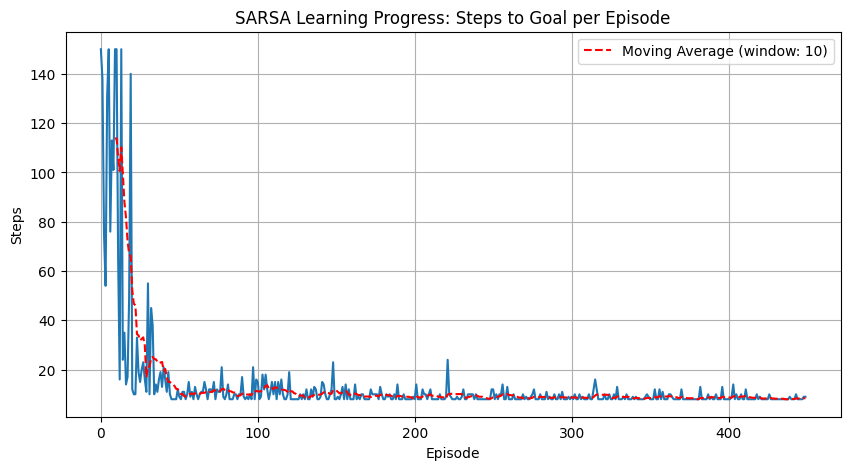


Final Learned Policy:
→ → → ↓ ↓
→ → → ↓ ↓
↓ → ↑ ↓ ←
↑ → ↑ → ↓
↑ ↑ ↑ ↑ G

Agent Movement Simulation with Learned Policy:
S . . . . 
. . . . . 
. . . . . 
. . . . . 
. . . . G 

Step 1: Action=right, Reward=0.0
S A . . . 
. . . . . 
. . . . . 
. . . . . 
. . . . G 

Step 2: Action=right, Reward=0.0
S X A . . 
. . . . . 
. . . . . 
. . . . . 
. . . . G 

Step 3: Action=right, Reward=0.0
S X X A . 
. . . . . 
. . . . . 
. . . . . 
. . . . G 

Step 4: Action=down, Reward=0.0
S X X X . 
. . . A . 
. . . . . 
. . . . . 
. . . . G 

Step 5: Action=down, Reward=0.0
S X X X . 
. . . X . 
. . . A . 
. . . . . 
. . . . G 

Step 6: Action=down, Reward=0.0
S X X X . 
. . . X . 
. . . X . 
. . . A . 
. . . . G 

Step 7: Action=right, Reward=0.0
S X X X . 
. . . X . 
. . . X . 
. . . X A 
. . . . G 

Step 8: Action=down, Reward=1
S X X X . 
. . . X . 
. . . X . 
. . . X X 
. . . . G 

Goal reached! Total steps: 8


In [16]:
# 메인 실행 코드
def main():
    # 환경 초기화
    env = MyGridWorldEnvironment(start_point=(0,0), 
                               end_point=(4,4), 
                               grid_world_size=(5,5))
    
    # SARSA 에이전트 초기화
    agent = SARSA(env, learning_rate=0.1, discount_factor=0.9, epsilon=0.3)
    
    # 학습 시작
    print("Starting SARSA learning...")
    step_counts = agent.learn(num_episodes=450, max_steps=150)
    print("Learning completed!")
    
    # 학습 곡선 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(step_counts)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.title('SARSA Learning Progress: Steps to Goal per Episode')
    plt.grid(True)
    
    # 이동 평균선
    window_size = 10
    if len(step_counts) > window_size:
        moving_avg = np.convolve(step_counts, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(step_counts)), moving_avg, 'r--', 
                 label=f'Moving Average (window: {window_size})')
        plt.legend()
    
    plt.show()
    
    # 최종 학습된 정책 출력
    print("\nFinal Learned Policy:")
    action_symbols = {0: "↑", 1: "↓", 2: "←", 3: "→"}
    for i in range(env.height):
        policy_row = []
        for j in range(env.width):
            if (i, j) == env.end_point:
                policy_row.append("G")
            else:
                best_action = np.argmax(agent.q_table[i, j])
                policy_row.append(action_symbols[best_action])
        print(" ".join(policy_row))
    
    # 학습된 정책으로 테스트 실행
    print("\nAgent Movement Simulation with Learned Policy:")
    state = env.reset()
    env.render()
    
    steps = 0
    max_steps = 30
    
    while state != env.end_point and steps < max_steps:
        # 탐험 없이 최적 정책만 따름
        action = np.argmax(agent.q_table[state[0], state[1]])
        next_state, reward = env.move(action)
        
        print(f"Step {steps+1}: Action={env.action_space[action]}, Reward={reward}")
        env.render()
        time.sleep(0.5)  # 시각화를 위한 일시 정지
        
        state = next_state
        steps += 1
    
    # 결과 출력
    if state == env.end_point:
        print(f"Goal reached! Total steps: {steps}")
    else:
        print("Maximum steps reached.")

if __name__ == "__main__":
    main()